<a href="https://colab.research.google.com/github/ILYSHI/Neuronets/blob/main/Dirty_vs_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.getcwd()

'/content'

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user Ilyshi — sort-by dateRun

!kaggle competitions download -c platesv2

!unzip -q train.csv.zip -d .
!unzip -q test.csv.zip -d .
!ls

Saving kaggle.json to kaggle.json
kaggle.json
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: — user Ilyshi — sort-by dateRun
 87% 41.0M/47.1M [00:00<00:00, 32.6MB/s]
100% 47.1M/47.1M [00:00<00:00, 53.8MB/s]
  0% 0.00/8.00k [00:00<?, ?B/s]
100% 8.00k/8.00k [00:00<00:00, 6.96MB/s]
unzip:  cannot find or open train.csv.zip, train.csv.zip.zip or train.csv.zip.ZIP.
unzip:  cannot find or open test.csv.zip, test.csv.zip.zip or test.csv.zip.ZIP.
kaggle.json  plates.zip  sample_data  sample_submission.csv


In [2]:
import numpy as np 
import pandas as pd
  
import os 

import zipfile
with zipfile.ZipFile('./plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/kaggle/working/') 
print(os.listdir('/kaggle/working/'))

data_root = '/kaggle/working/plates/' 
print(data_root)
print(os.listdir(data_root))

['__MACOSX', 'plates']
/kaggle/working/plates/
['test', 'train', '.DS_Store']


In [61]:
import shutil 
from tqdm import tqdm

train_dir = 'train' # на этих данных будем обучать модель
val_dir = 'val' #на этих данных будем смотреть какую accuracy показывает наша модель 
 
class_names = ['cleaned', 'dirty']
 
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
 
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))




100%|██████████| 21/21 [00:00<00:00, 2877.22it/s]



100%|██████████| 21/21 [00:00<00:00, 1870.55it/s]


In [62]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models

train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.CenterCrop(160),
    transforms.Resize((224, 224)),    
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.CenterCrop(160),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),     
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])   

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


batch_size = 8 # Количество изображений в батче
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [63]:
len(train_dataloader), len(train_dataset)

(4, 32)

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line

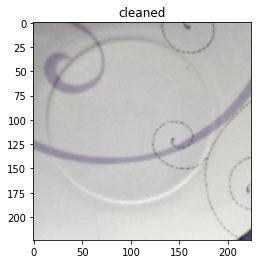

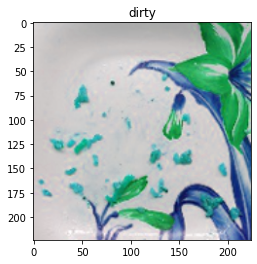

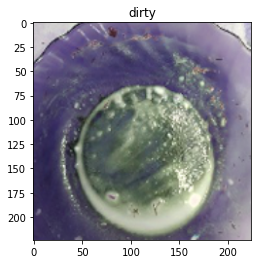

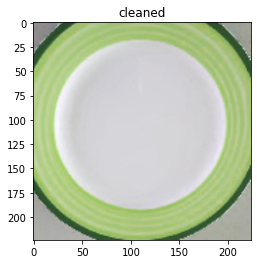

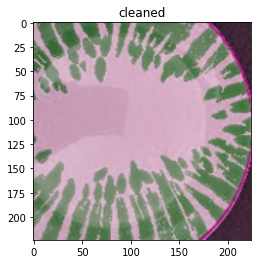

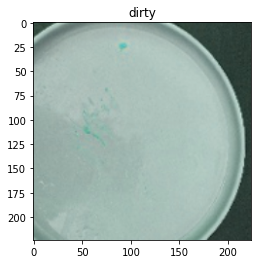

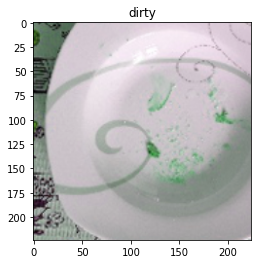

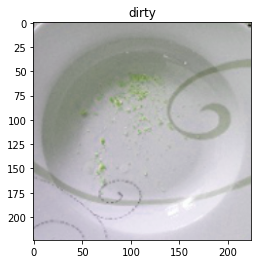

In [64]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)
 
X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [46]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        print("\r Epoch {}/{}:".format(epoch, num_epochs - 1), end="", flush=True)
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки  
                dataloader = train_dataloader #берем train_dataLoader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации 
                dataloader = val_dataloader #берем val_dataLoader 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе
 
            print("\r{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="", flush=True)
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [8]:
class MyResNet50(torch.nn.Module):
    def __init__(self,drop_out=0):
        super(MyResNet50, self).__init__()
        self.net = torchvision.models.resnet50(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Dropout(drop_out),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Decay LR by a factor of 0.1 every 7 epochs
model = MyResNet50(drop_out=0).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [66]:
model, loss, acc = train_model(model, loss,optimizer, scheduler,
                               num_epochs = 50)

 Epoch 0/49:

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

train Loss: 0.8101 Acc: 0.4688 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

 Epoch 1/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.47it/s]


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

train Loss: 0.7352 Acc: 0.5000 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

 Epoch 2/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.30it/s]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

train Loss: 0.6663 Acc: 0.5000 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

val Loss: 0.7029 Acc: 0.5000 

 Epoch 3/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.30it/s]


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

train Loss: 0.6230 Acc: 0.7500 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

 Epoch 4/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.37it/s]


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

train Loss: 0.5852 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

val Loss: 0.6741 Acc: 0.6250 

 Epoch 5/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

train Loss: 0.5716 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

val Loss: 0.6975 Acc: 0.6250 

 Epoch 6/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.27it/s]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

train Loss: 0.5368 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

 Epoch 7/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

train Loss: 0.5399 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

 Epoch 8/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.58it/s]


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

train Loss: 0.5251 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

 Epoch 9/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

train Loss: 0.5345 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

 Epoch 10/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.49it/s]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

train Loss: 0.5130 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

val Loss: 0.6507 Acc: 0.6250 

 Epoch 11/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.42it/s]


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

train Loss: 0.5359 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

val Loss: 0.6395 Acc: 0.6250 

 Epoch 12/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

train Loss: 0.5513 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

 Epoch 13/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.30it/s]


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.4929 Acc: 0.9688 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

 Epoch 14/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.73it/s]


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

train Loss: 0.5084 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

val Loss: 0.6764 Acc: 0.6250 

 Epoch 15/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

train Loss: 0.5437 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

 Epoch 16/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.04it/s]


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

train Loss: 0.5136 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

 Epoch 17/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

train Loss: 0.5392 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 Epoch 18/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.32it/s]


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

train Loss: 0.5300 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

 Epoch 19/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

train Loss: 0.4974 Acc: 0.9688 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

val Loss: 0.6742 Acc: 0.6250 

 Epoch 20/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.65it/s]


 50%|█████     | 2/4 [00:00<00:00,  2.06it/s]


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

train Loss: 0.5186 Acc: 0.7812 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 Epoch 21/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.42it/s]


 50%|█████     | 2/4 [00:00<00:01,  1.88it/s]


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

train Loss: 0.5385 Acc: 0.7812 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

val Loss: 0.6878 Acc: 0.6250 

 Epoch 22/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

train Loss: 0.5281 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 Epoch 23/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.24it/s]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

train Loss: 0.5188 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 Epoch 24/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.24it/s]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

train Loss: 0.5159 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

val Loss: 0.6856 Acc: 0.6250 

 Epoch 25/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.77it/s]


 50%|█████     | 2/4 [00:00<00:00,  2.21it/s]


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

train Loss: 0.5670 Acc: 0.7812 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 Epoch 26/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.29it/s]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

train Loss: 0.5065 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

 Epoch 27/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

train Loss: 0.5068 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

 Epoch 28/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.30it/s]


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

train Loss: 0.5367 Acc: 0.8125 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

val Loss: 0.6653 Acc: 0.5000 

 Epoch 29/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.63it/s]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

train Loss: 0.5355 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

 Epoch 30/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

train Loss: 0.5466 Acc: 0.8125 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

 Epoch 31/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.29it/s]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

train Loss: 0.5284 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

 Epoch 32/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.34it/s]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

train Loss: 0.5690 Acc: 0.7812 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 Epoch 33/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.32it/s]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

train Loss: 0.5088 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

 Epoch 34/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.39it/s]


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

train Loss: 0.5475 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

 Epoch 35/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.23it/s]


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

train Loss: 0.5312 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

 Epoch 36/49:





  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

train Loss: 0.5369 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

val Loss: 0.6716 Acc: 0.6250 

 Epoch 37/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.42it/s]


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

train Loss: 0.5268 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 Epoch 38/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.26it/s]


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

train Loss: 0.4958 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 Epoch 39/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

train Loss: 0.5369 Acc: 0.8125 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

 Epoch 40/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

train Loss: 0.5315 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

 Epoch 41/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.29it/s]


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

train Loss: 0.5518 Acc: 0.8125 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

val Loss: 0.6871 Acc: 0.6250 

 Epoch 42/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.23it/s]


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

train Loss: 0.5467 Acc: 0.8125 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

 Epoch 43/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.54it/s]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

train Loss: 0.5106 Acc: 0.9688 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

 Epoch 44/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

train Loss: 0.5321 Acc: 0.8750 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

val Loss: 0.6668 Acc: 0.6250 

 Epoch 45/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

train Loss: 0.5550 Acc: 0.8125 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

 Epoch 46/49:





  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.35it/s]


100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

train Loss: 0.5312 Acc: 0.8438 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 Epoch 47/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.32it/s]


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

train Loss: 0.5163 Acc: 0.9375 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

val Loss: 0.6541 Acc: 0.6250 

 Epoch 48/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:02,  1.39it/s]


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

train Loss: 0.5073 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

val Loss: 0.6843 Acc: 0.5000 

 Epoch 49/49:




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:00<00:01,  1.71it/s]


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

train Loss: 0.5153 Acc: 0.9062 





  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

val Loss: 0.7030 Acc: 0.5000 

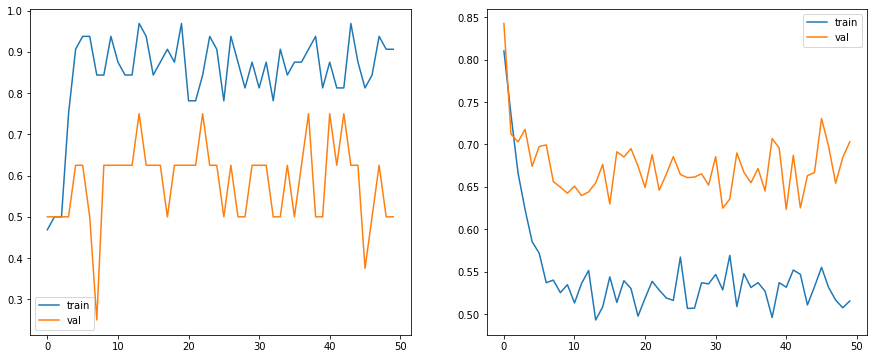

In [67]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(acc['train'],label='train')
plt.plot(acc['val'],label='val')
plt.legend()
plt.subplot(122)
plt.plot(loss['train'],label='train')
plt.plot(loss['val'],label='val')
plt.legend()

In [68]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), 
                os.path.join(test_dir, 'unknown'))

'test/unknown'

In [16]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [69]:
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers = batch_size
)

In [70]:
model.eval();

In [71]:
test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)




  0%|          | 0/93 [00:00<?, ?it/s]


  1%|          | 1/93 [00:00<01:27,  1.05it/s]


  2%|▏         | 2/93 [00:01<01:10,  1.29it/s]


  4%|▍         | 4/93 [00:01<00:50,  1.75it/s]


  6%|▋         | 6/93 [00:01<00:37,  2.35it/s]


  9%|▊         | 8/93 [00:01<00:26,  3.15it/s]


 10%|▉         | 9/93 [00:02<00:23,  3.57it/s]


 11%|█         | 10/93 [00:02<00:21,  3.90it/s]


 13%|█▎        | 12/93 [00:02<00:16,  4.85it/s]


 14%|█▍        | 13/93 [00:02<00:13,  5.72it/s]


 15%|█▌        | 14/93 [00:02<00:12,  6.29it/s]


 17%|█▋        | 16/93 [00:02<00:10,  7.57it/s]


 19%|█▉        | 18/93 [00:03<00:12,  6.10it/s]


 22%|██▏       | 20/93 [00:03<00:10,  7.21it/s]


 23%|██▎       | 21/93 [00:03<00:09,  7.48it/s]


 25%|██▍       | 23/93 [00:03<00:08,  8.43it/s]


 27%|██▋       | 25/93 [00:03<00:07,  9.31it/s]


 29%|██▉       | 27/93 [00:04<00:08,  7.94it/s]


 31%|███       | 29/93 [00:04<00:07,  8.78it/s]


 33%|███▎      | 31/93 [00:04<00:06,  9.41it/s]


 35%|███▌   

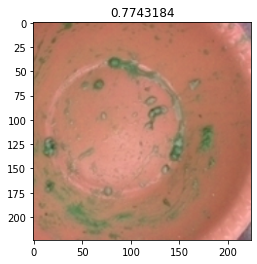

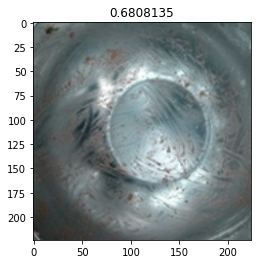

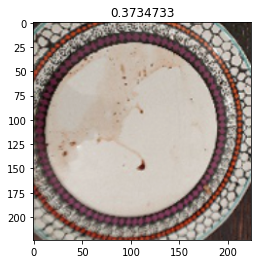

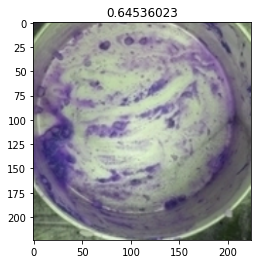

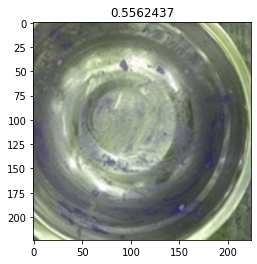

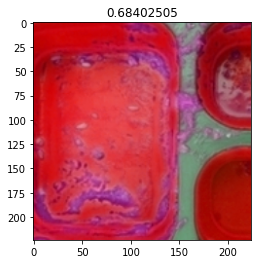

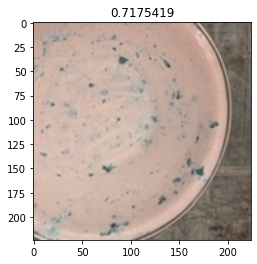

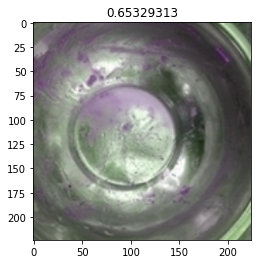

In [72]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [73]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [74]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)


,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [75]:
submission_df.to_csv('submission.csv')

In [82]:
!kaggle competitions submit -c platesv2 -f submission.csv -m "resnet50, dp = 0, Adam, scheduler step=5, crop 160,"

100% 8.12k/8.12k [00:03<00:00, 2.12kB/s]
Successfully submitted to Cleaned vs Dirty V2

In [83]:
!rm -rf train val test

In [84]:
!kaggle competitions submissions -c platesv2

fileName            date                 description                                          status    publicScore  privateScore  
------------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission.csv      2021-02-04 19:09:10  resnet50, dp = 0, Adam, scheduler step=5, crop 160,  complete  0.69354      None          
submission.csv      2021-02-04 19:05:09  Message                                              complete  0.69354      None          
submission.csv      2021-02-04 19:00:21  Message                                              complete  0.68279      None          
submission.csv      2021-02-04 18:18:18  Message                                              complete  0.76209      None          
submission (5).csv  2021-02-04 18:17:45  Fixed Resnet50                                       complete  0.76209      None          
submission (4).csv  2021-02-04 15:54:14  None                               